# 03. Exploratory Data Analysis
__Capstone project: Duration of the insertion of real estate advertisements for rental apartments in Switzerland__

In this document, I will have a deeper look into my combined data and see if I can detect any interesting patterns, correlations and potential difficulties.

In [1]:
%load_ext lab_black

In [2]:
# surpress Pandas FutureWarning
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# import commands
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# import the data

df = pd.read_csv(
    "Data/ads&stats_after_eda.csv",
    delimiter=",",
    dtype={"Minergie": "str", "Rollstuhlgängig": "str"},
)  # specify the column types to avoid DtypeWarning


# shape of the data
df.shape

(921886, 31)

In [4]:
## add column with non-logarithmic values for ``Insertionsdauer`` for visualisations
df["Insertionsdauer_n"] = np.exp(df["Insertionsdauer"])

## Statistics

In [5]:
df["Insertionsdauer_n"].describe().round(1)

count    921886.0
mean         56.5
std          66.6
min           3.0
25%          14.0
50%          29.0
75%          71.0
max         364.0
Name: Insertionsdauer_n, dtype: float64

## Geographical distribution

### Location of advertisements 

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [7]:
# Shapefile of the shape of municipalities in switzerland
municipality_map = gpd.read_file("data/ag-b-00.03-875-gg21/ggg_2021-LV95/shp/g1g21.shp")

In [8]:
# Shapefile of the shape of lakes in switzerland
lake_map = gpd.read_file("data/ag-b-00.03-875-gg21/ggg_2021-LV95/shp/g1s21.shp")

In [9]:
# get my data into a GeoPandas Dataframe with the specified CRS
# transform the latitude and longitude into geometric points
crs = {"init": "EPSG:4326"}
geometry = [Point(xy) for xy in zip(df["Längengrad"], df["Breitengrad"])]
geo_df = gpd.GeoDataFrame(
    df, crs=crs, geometry=gpd.points_from_xy(df.Längengrad, df.Breitengrad)
)

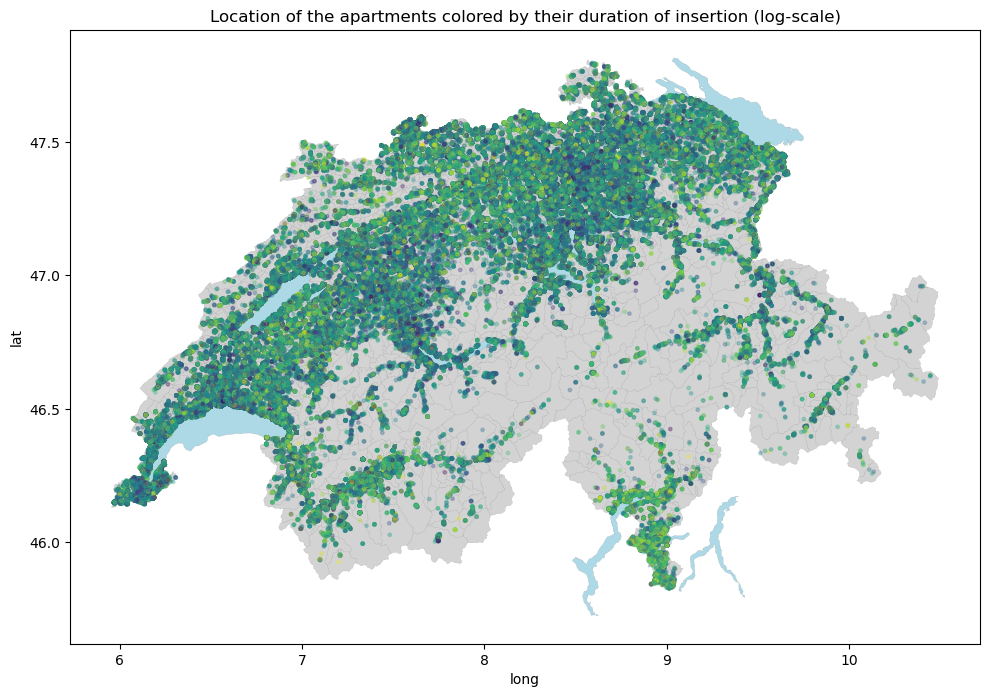

In [10]:
# plot the map with the underlying shapefile
fig, ax = plt.subplots(figsize=(10, 10))

# plot the municipalities
municipality_map.to_crs(epsg=4326).plot(
    ax=ax, color="lightgrey", linewidth=0.1, edgecolor="0.5"
)
# plot the lakes
lake_map.to_crs(epsg=4326).plot(
    ax=ax, color="lightblue", linewidth=0.1, edgecolor="0.5"
)

# plot the actual points
geo_df.plot(ax=ax, alpha=0.3, markersize=6, c=geo_df.Insertionsdauer)

# title and labels
ax.set_title(
    "Location of the apartments colored by their duration of insertion (log-scale)"
)
plt.xlabel("long")
plt.ylabel("lat")
plt.tight_layout()
plt.show()

This map does not show much, as there are to many datapoints for any pattern for the duration of insertion to be visible. However, we see that the mayority of the advertisements are located in the north part of Switzerland with some hotspots in the vallys of the alps and in Ticino. 

Next, I want to plot a choropleth map of Switzerland, where every mean duration of insertion per municipality is showed. I will exclude municipalities with less than 25 advertisements, as they might have a distorted mean. 

### Choropleth map

In [11]:
# show total count of unique municipalities
df["Gemeinde"].nunique()

2121

In [12]:
# get the mean duration of insertion per municipality if there are more than 25 advertisements
municipality_df = (
    df[
        df["Gemeinde"].isin(
            df["Gemeinde"].value_counts()[df["Gemeinde"].value_counts() >= 25].index
        )
    ]
    .groupby(["Gemeinde"])[["Insertionsdauer", "Insertionsdauer_n"]]
    .mean()
)

municipality_df.reset_index(level=0, inplace=True)

In [13]:
# rename the columns
municipality_df.rename(
    columns={
        municipality_df.columns[1]: "mean_insertion_log",
        municipality_df.columns[2]: "mean_insertion_normal",
    },
    inplace=True,
)

In [14]:
municipality_df.shape

(1763, 3)

In [15]:
municipality_map.columns

Index(['GMDHISTID', 'GMDNR', 'GMDNAME', 'BZHISTID', 'BZNR', 'KTNR', 'GRNR',
       'AREA_HA', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX', 'E_CNTR', 'N_CNTR',
       'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR', 'X_MIN', 'X_MAX', 'Y_MIN',
       'Y_MAX', 'X_CNTR', 'Y_CNTR', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [16]:
# compare
map_unique = municipality_map["GMDNAME"].unique()
mun_unique = municipality_df["Gemeinde"].unique()

In [17]:
len(list(set(map_unique) - set(mun_unique)))

419

In [18]:
len(list(set(mun_unique) - set(map_unique)))

7

There are quite some mismatched between my dataset and the map. There are some municipalities not present in the map and some not present in my df. However, as I only use the map to get some visual insights, I will not correct the mismatches.

In [19]:
map_merged = municipality_map.merge(
    municipality_df, how="outer", left_on=["GMDNAME"], right_on=["Gemeinde"]
)

In [20]:
map_merged.columns

Index(['GMDHISTID', 'GMDNR', 'GMDNAME', 'BZHISTID', 'BZNR', 'KTNR', 'GRNR',
       'AREA_HA', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX', 'E_CNTR', 'N_CNTR',
       'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR', 'X_MIN', 'X_MAX', 'Y_MIN',
       'Y_MAX', 'X_CNTR', 'Y_CNTR', 'Shape_Leng', 'Shape_Area', 'geometry',
       'Gemeinde', 'mean_insertion_log', 'mean_insertion_normal'],
      dtype='object')

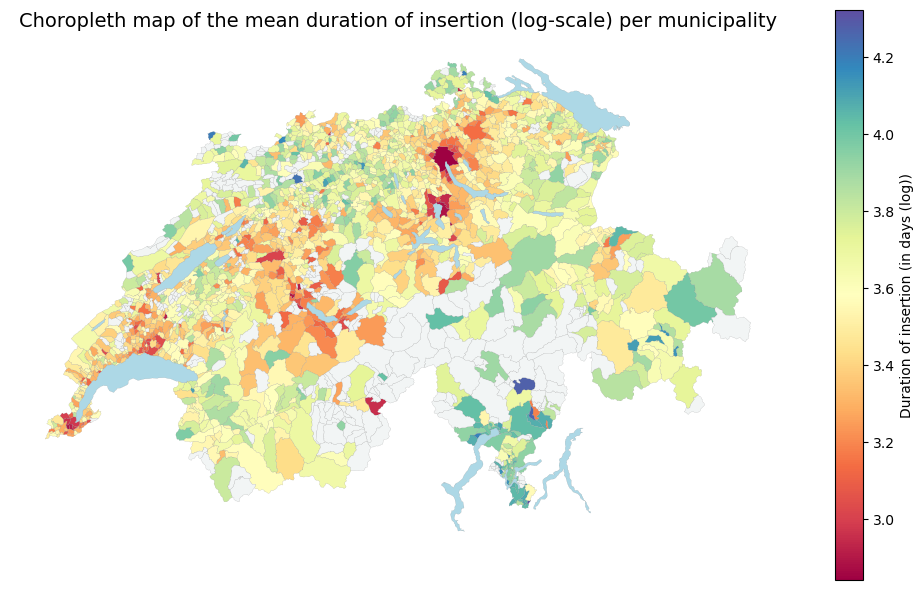

In [21]:
from matplotlib import cm

# color
cmap = cm.get_cmap("Spectral")

fig, ax = plt.subplots(1, figsize=(10, 6))

# plot the choropleth map
base = map_merged.plot(
    column="mean_insertion_log",
    cmap=cmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="0.5",
    legend=True,
    legend_kwds={"label": "Duration of insertion (in days (log))"},
    missing_kwds={
        "color": "#f2f5f5",
        "label": "Missing values",
    },
)

# plot the lakes
lake_map.plot(ax=base, color="lightblue", linewidth=0.1, edgecolor="0.5")

# title, axis,...
ax.axis("off")
ax.set_title(
    "Choropleth map of the mean duration of insertion (log-scale) per municipality",
    fontsize=14,
)
plt.tight_layout()
plt.show()

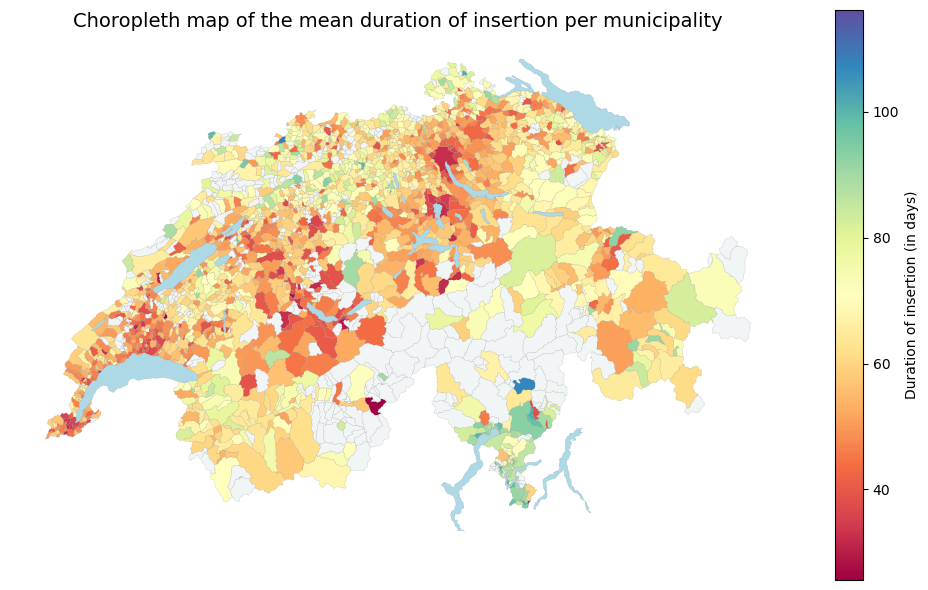

In [22]:
from matplotlib import cm

# color
cmap = cm.get_cmap("Spectral")

fig, ax = plt.subplots(1, figsize=(10, 6))

# plot the choropleth map
base = map_merged.plot(
    column="mean_insertion_normal",
    cmap=cmap,
    linewidth=0.1,
    ax=ax,
    edgecolor="0.5",
    legend=True,
    legend_kwds={"label": "Duration of insertion (in days)"},
    missing_kwds={
        "color": "#f2f5f5",
        "label": "Missing values",
    },
)

# plot the lakes
lake_map.plot(ax=base, color="lightblue", linewidth=0.1, edgecolor="0.5")

# title, axis,...
ax.axis("off")
ax.set_title(
    "Choropleth map of the mean duration of insertion per municipality",
    fontsize=14,
)
plt.tight_layout()
plt.show()

The municipalities have a very different insertion periods, some spatial differences can be seen clearly. In both of the above plots, the canton of Ticino stands out with long duration of insertion. Big cities as Zurich or Geneva have very short durations, but also smaller cities like Zug or Winterthur. Let's have a look at the top 5 municipalities with the shortest and longest mean of duration.

In [23]:
# show the top 5 municipalities with the shortest mean duration of insertion
map_merged[["Gemeinde", "mean_insertion_log", "mean_insertion_normal"]].sort_values(
    by=["mean_insertion_normal"], ascending=True
).head(5)

Gemeinde  mean_insertion_log  mean_insertion_normal
1696   Ried-Brig            2.953760              25.592593
1512     Boulens            2.919234              26.545455
2064    Gurzelen            2.905294              27.074074
1690  Wilderswil            3.037563              29.789474
1435  Bonvillars            3.005665              30.071429

Zurich is the municipality with the shorest duration of insertion!

In [24]:
# show the top 5 municipalities with the longest mean duration of insertion
map_merged[["Gemeinde", "mean_insertion_log", "mean_insertion_normal"]].sort_values(
    by=["mean_insertion_normal"], ascending=False
).head(5)

Gemeinde  mean_insertion_log  mean_insertion_normal
1315               Vacallo            4.322821             116.196013
398   Metzerlen-Mariastein            4.161241             108.153846
1317                Biasca            4.271918             107.262774
1269                 Curio            4.111709             101.941176
1222                Lumino            4.267309             101.662338

Vacallo, Biasca and Lumino are all in the canton Ticino.

## Visualisations

In [25]:
# drop columns, not needed anymore
df = df.drop(["Gemeinde", "Längengrad", "Breitengrad", "geometry"], axis=1)

### Correlation to first date published

In [28]:
# get the mean duration of insertion per year
year_df = df.groupby(["Jahr_Erste_Publikation"])[
    ["Insertionsdauer", "Insertionsdauer_n"]
].mean()

year_df.reset_index(level=0, inplace=True)

In [29]:
# rename the columns
year_df.rename(
    columns={
        year_df.columns[1]: "mean of duration of insertion (log)",
        year_df.columns[2]: "mean of duration of insertion (normal)",
    },
    inplace=True,
)
year_df.head(6).round(1)

Jahr_Erste_Publikation  mean of duration of insertion (log)  \
0                    2015                                  3.4   
1                    2016                                  3.4   
2                    2017                                  3.5   
3                    2018                                  3.5   
4                    2019                                  3.5   
5                    2020                                  3.4   

   mean of duration of insertion (normal)  
0                                    54.7  
1                                    53.5  
2                                    58.6  
3                                    58.8  
4                                    58.9  
5                                    55.0

I the year 2020, followed by the years 2015 and 2016, the mean duration of insertion was the shortest. 

In [30]:
# get the mean duration of insertion per month
month_df = df.groupby(["Monat_Erste_Publikation"])[
    ["Insertionsdauer", "Insertionsdauer_n"]
].mean()

month_df.reset_index(level=0, inplace=True)

In [31]:
# rename the columns
month_df.rename(
    columns={
        month_df.columns[1]: "mean of duration of insertion (log)",
        month_df.columns[1]: "mean of duration of insertion (normal)",
    },
    inplace=True,
)
month_df.head(12).round(1)

Monat_Erste_Publikation  mean of duration of insertion (normal)  \
0                         1                                     3.4   
1                         2                                     3.4   
2                         3                                     3.3   
3                         4                                     3.5   
4                         5                                     3.4   
5                         6                                     3.5   
6                         7                                     3.5   
7                         8                                     3.4   
8                         9                                     3.5   
9                        10                                     3.5   
10                       11                                     3.5   
11                       12                                     3.5   

    Insertionsdauer_n  
0                54.1  
1                52.8  
2                53.2  
3                58.3  
4                57.1  
5                58.3  
6                58.7  
7                56.7  
8                56.4  
9                56.9  
10               57.0  
11               58.1

There is a seasonal trend in the data. During december the duration of insertion is the longest. A common convention in Switzerland is to move out of your apartment at the end of the month. But because of the holidays at the end of December there is almost no change of apartment. Therefore, the duration of insertion is longer for December. In February and March the duration is the shortest. 

In [32]:
# get the mean duration of insertion per year and moth
count_time = df.groupby(["Jahr_Erste_Publikation", "Monat_Erste_Publikation"])[
    "Insertionsdauer_n"
].mean()

In [33]:
# Series to dataframe
time_df = count_time.to_frame().reset_index()

# rename the columns
time_df.rename(
    columns={time_df.columns[2]: "mean of duration of insertion (normal)"},
    inplace=True,
)

In [34]:
# pivot
time_df = time_df.pivot(
    "Jahr_Erste_Publikation",
    "Monat_Erste_Publikation",
    "mean of duration of insertion (normal)",
)

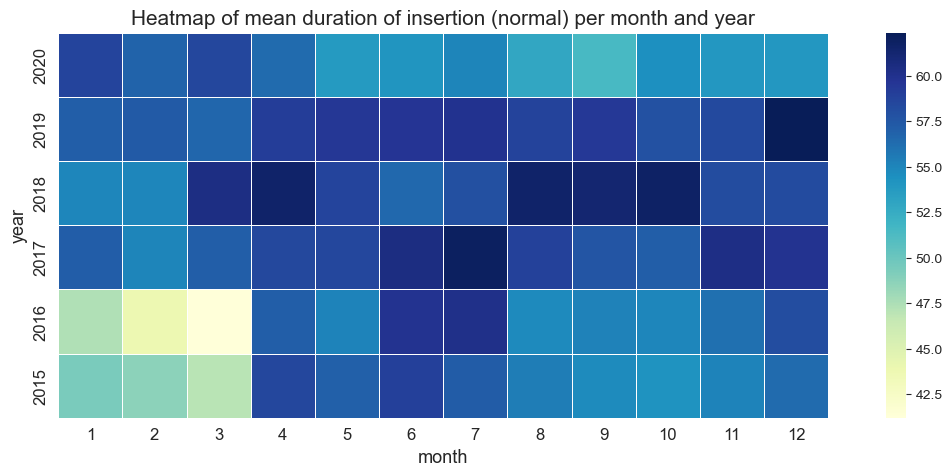

In [35]:
# sort the months from 1 to 12
time_df.sort_index(level=0, ascending=False, inplace=True)

# Plot correlation matrix
sns.set_style("dark")
plt.figure(figsize=(15, 5))
seasons = sns.heatmap(time_df, square=True, linewidths=0.5, cmap="YlGnBu")

seasons.set_title(
    "Heatmap of mean duration of insertion (normal) per month and year", fontsize=15
)
seasons.set_xlabel("month", fontsize=13)
seasons.set_ylabel("year", fontsize=13)
seasons.tick_params(labelsize=12)

plt.show()

The months January, February and March of the years 2015 and 2016 stand out with very short durations. I can not explain this trend.

### Correlation to condition category

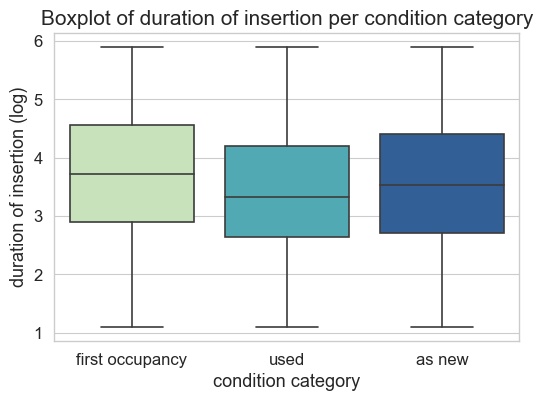

In [36]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="whitegrid", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.4)

chart = sns.boxplot(x=df["Zustand"], y=df.Insertionsdauer, palette="YlGnBu")

chart.set_title("Boxplot of duration of insertion per condition category", fontsize=15)
chart.set_xlabel("condition category", fontsize=13)
chart.set_ylabel("duration of insertion (log)", fontsize=13)
chart.tick_params(labelsize=12)
chart.set_xticklabels(["first occupancy", "used", "as new"])

plt.show()

Apartments which are used have a longer duration of insertion than new ones and first occupancy ones. If the apartment is a first occupancy, the duration of insertion is the longest.

### Correlation to category of availability

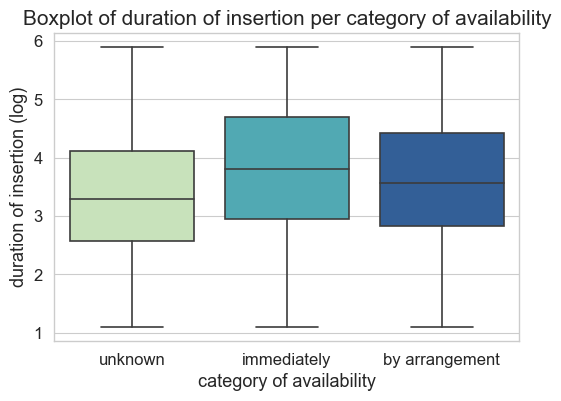

In [37]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="whitegrid", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.4)

chart = sns.boxplot(
    x=df["Verfügbarkeitskategorie"], y=df.Insertionsdauer, palette="YlGnBu"
)

chart.set_title(
    "Boxplot of duration of insertion per category of availability", fontsize=15
)
chart.set_xlabel("category of availability", fontsize=13)
chart.set_ylabel("duration of insertion (log)", fontsize=13)
chart.tick_params(labelsize=12)
chart.set_xticklabels(["unknown", "immediately", "by arrangement"])

plt.show()

If the apartment is available immediately, the duration of insertion is longer than if the availability is unknown.

### Correlation to number of rooms

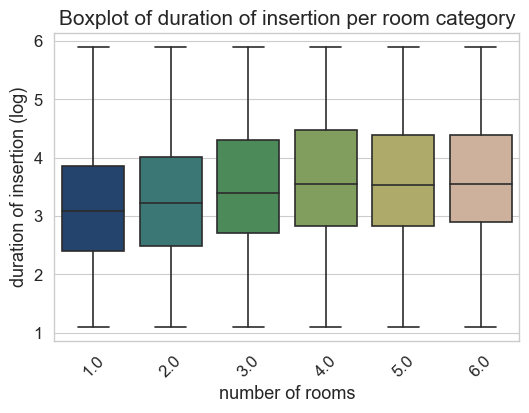

In [38]:
# only show apartments with up to 6 rooms
rooms_filtered = df.loc[df["Anzahl Zimmer"] <= 6]

sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="whitegrid", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.4)

# boxplot of duration of insertion per number of rooms
chart = sns.boxplot(
    x=rooms_filtered["Anzahl Zimmer"], y=df.Insertionsdauer, palette="gist_earth"
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_title("Boxplot of duration of insertion per room category", fontsize=15)
chart.set_xlabel("number of rooms", fontsize=13)
chart.set_ylabel("duration of insertion (log)", fontsize=13)
chart.tick_params(labelsize=12)

plt.show()

For apartments up to 4 rooms, the duration of insertions increases with the number of rooms. Apartments with 5 or 6 rooms have a similar duration as 4 room apartments.

### Correlation to spatial categories

In [39]:
# Replace a single value with a new value
df["3 Gmd Kat"] = df["3 Gmd Kat"].replace(
    ["Intermediär (dichter periurbaner Raum und ländliche Zentren)"], "Intermediär"
)

In [40]:
# get the mean duration of insertion for the 3 spatial categories
count_3 = df.groupby(["3 Gmd Kat"])["Insertionsdauer_n"].mean()

count_3.sort_values().round(1)

3 Gmd Kat
Städtisch      54.4
Intermediär    61.0
Ländlich       62.5
Name: Insertionsdauer_n, dtype: float64

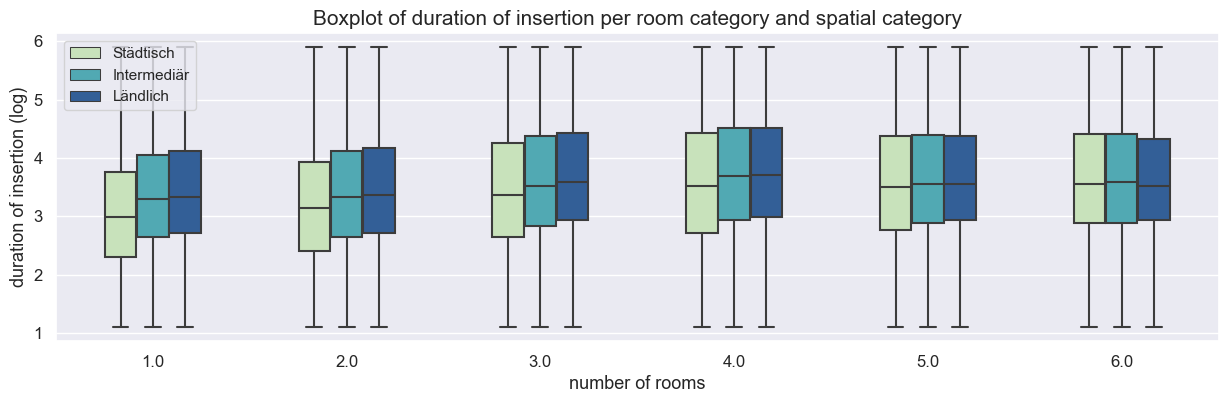

In [41]:
# get the mean duration of insertion for the 3 spatial categories per number of rooms

# plot boxplot
sns.set(rc={"figure.figsize": (15, 4)})
chart = sns.boxplot(
    x=rooms_filtered["Anzahl Zimmer"],
    y="Insertionsdauer",
    hue="3 Gmd Kat",
    data=df,
    palette="YlGnBu",
    width=0.5,
    hue_order=[
        "Städtisch",
        "Intermediär",
        "Ländlich",
    ],
)

# add title and labels
chart.set_title(
    "Boxplot of duration of insertion per room category and spatial category",
    fontsize=15,
)
chart.set_xlabel("number of rooms", fontsize=13)
chart.set_ylabel("duration of insertion (log)", fontsize=13)
chart.tick_params(labelsize=12)

# move hue legend
plt.legend(loc="upper left")

plt.show()

For apartments with 4 or moore rooms, there is only a slight difference between the 3 spatial categories. However for apartments with 1 to 3 rooms, the duration of insertion is shortest for the urban regions and longest for the rural regions.

In [42]:
# get the mean duration of insertion for the 9 categories
count_9 = df.groupby(["9 Gmd Kat"])["Insertionsdauer_n"].mean()
count_9.sort_values().round(1)

9 Gmd Kat
Städtische Gemeinde einer grossen Agglomeration                          46.0
Periurbane Gemeinde geringer Dichte                                      58.2
Periurbane Gemeinde hoher Dichte                                         59.3
Periurbane Gemeinde mittlerer Dichte                                     60.1
Städtische Gemeinde einer mittelgrossen Agglomeration                    61.8
Städtische Gemeinde einer kleinen oder ausserhalb einer Agglomeration    63.4
Ländliche zentral gelegene Gemeinde                                      64.5
Ländliche periphere Gemeinde                                             65.7
Ländliche Zentrumsgemeinde                                               66.8
Name: Insertionsdauer_n, dtype: float64

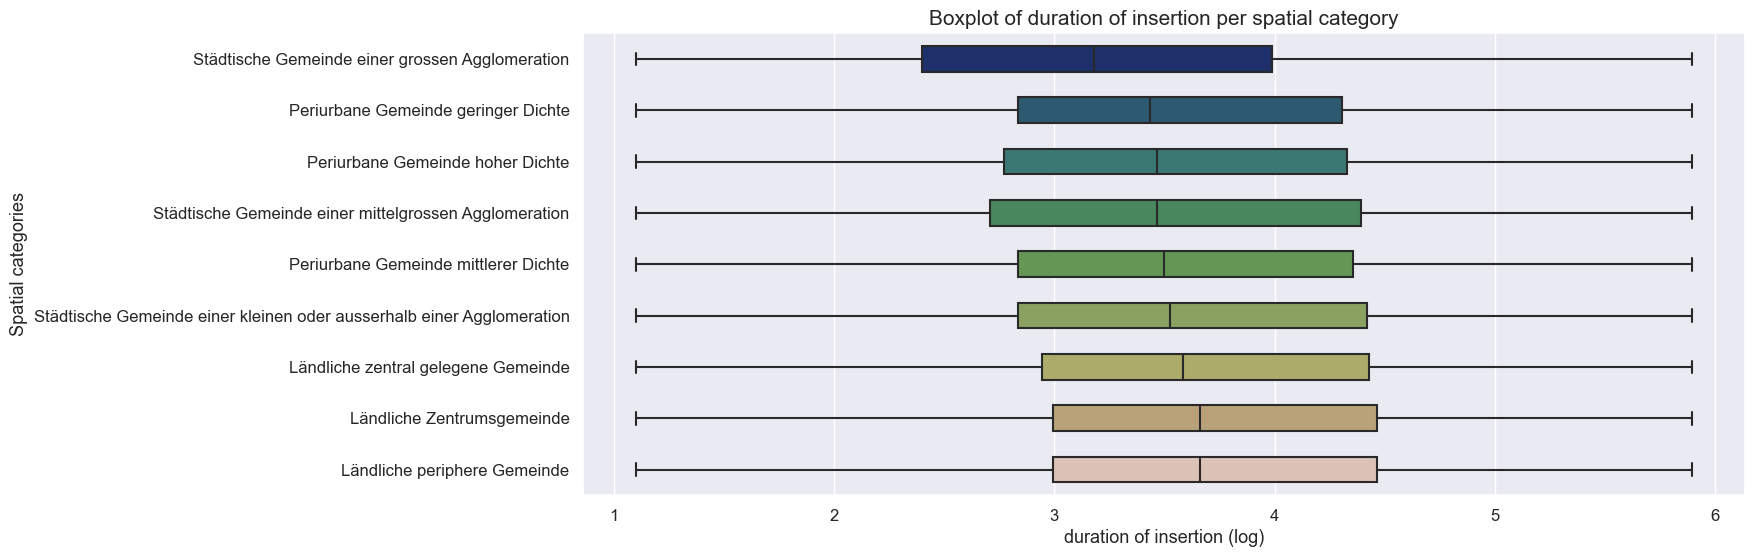

In [43]:
sns.set(rc={"figure.figsize": (15, 6)})

# order boxplot by median
grouped = (
    df.loc[:, ["9 Gmd Kat", "Insertionsdauer"]]
    .groupby(["9 Gmd Kat"])
    .median()
    .sort_values(by="Insertionsdauer")
)

# plot boxplot
chart = sns.boxplot(
    x="Insertionsdauer",
    y="9 Gmd Kat",
    data=df,
    palette="gist_earth",
    width=0.5,
    order=grouped.index,
)

chart.set_title(
    "Boxplot of duration of insertion per spatial category",
    fontsize=15,
)
chart.set_xlabel("duration of insertion (log)", fontsize=13)
chart.set_ylabel("Spatial categories", fontsize=13)
chart.tick_params(labelsize=12)

plt.show()

In [44]:
# get the mean duration of insertion for the 25 categories
count_25 = df.groupby(["25 Gmd Kat"])["Insertionsdauer_n"].mean()
count_25.sort_values().round(1)

25 Gmd Kat
Kernstadt einer grossen Agglomeration                                                   38.9
Städtische Arbeitsplatzgemeinde einer grossen Agglomeration                             49.5
Städtische Wohngemeinde einer grossen Agglomeration                                     51.9
Periurbane Agrargemeinde geringer Dichte                                                55.5
Städtische Tourismusgemeinde einer kleinen oder ausserhalb einer Agglomeration          56.0
Periurbane Dienstleistungsgemeinde geringer Dichte                                      58.4
Periurbane Dienstleistungsgemeinde mittlerer Dichte                                     59.1
Periurbane Industriegemeinde hoher Dichte                                               59.2
Periurbane Industriegemeinde geringer Dichte                                            59.4
Periurbane Dienstleistungsgemeinde hoher Dichte                                         59.5
Kernstadt einer mittelgrossen Agglomeration                

In [45]:
# get the mean duration of insertion for the cantons
canton = df.groupby(["Kanton"])["Insertionsdauer_n"].mean()
canton.sort_values().round(1)

Kanton
ZG    36.8
GE    39.5
ZH    46.6
BS    49.6
VD    49.8
BE    53.7
LU    54.8
AI    54.8
OW    55.0
NW    55.5
SZ    57.3
GR    58.9
FR    59.2
NE    62.3
UR    62.6
TG    64.0
AG    64.5
VS    65.6
SG    65.9
BL    66.1
GL    68.1
AR    71.7
SO    72.6
JU    74.9
SH    75.2
TI    88.1
Name: Insertionsdauer_n, dtype: float64

In general, big cities have shorter durations of insertion then towns and villages in the countryside. The cantons with the shortest duration are Zug and Geneva. The canton with the largest duration by far is Ticino. 

### Correlation to surface area

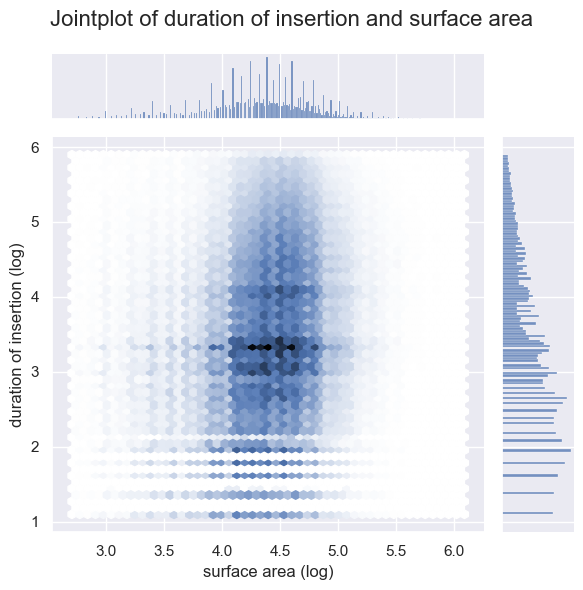

In [46]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(x="Wohnfläche", y="Insertionsdauer", data=df, kind="hex")
fig.fig.suptitle("Jointplot of duration of insertion and surface area", fontsize=16)
fig.set_axis_labels("surface area (log)", "duration of insertion (log)", fontsize=12)
fig.fig.tight_layout()
plt.show()

### Correlation to net rent

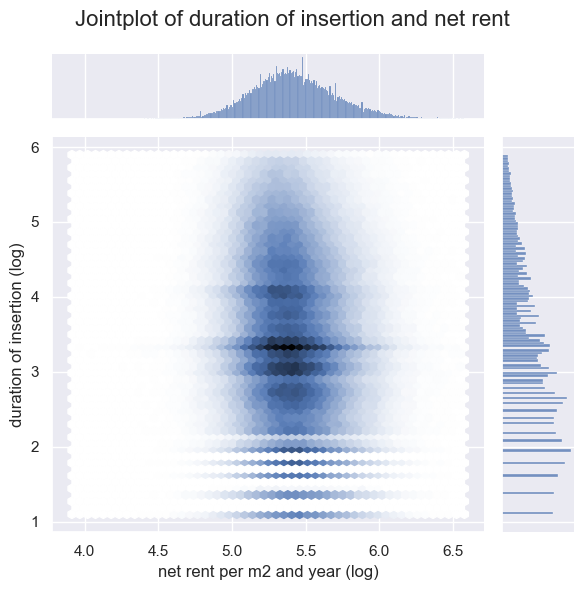

In [47]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(
    x="Nettomiete pro m2 und Jahr", y="Insertionsdauer", data=df, kind="hex"
)
fig.fig.suptitle("Jointplot of duration of insertion and net rent", fontsize=16)
fig.set_axis_labels(
    "net rent per m2 and year (log)", "duration of insertion (log)", fontsize=12
)
fig.fig.tight_layout()
plt.show()

### Correlation to share of 3-4 room apartments

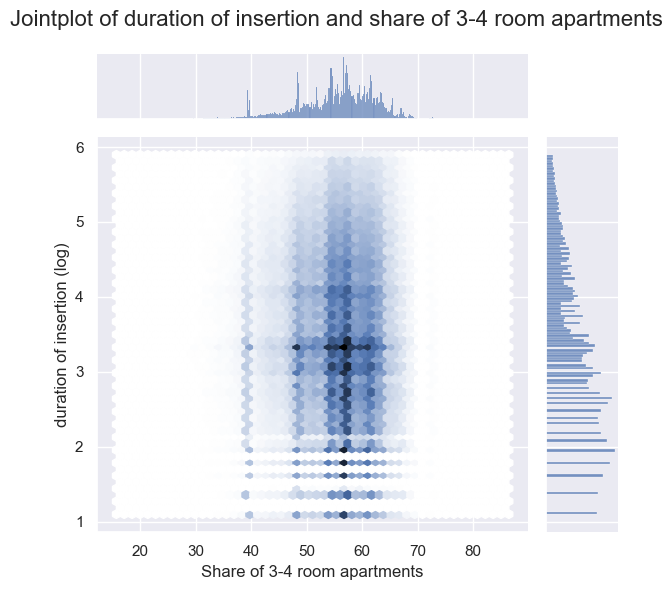

In [48]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(
    x="Share of 3-4 room apartments", y="Insertionsdauer", data=df, kind="hex"
)
fig.fig.suptitle(
    "Jointplot of duration of insertion and share of 3-4 room apartments", fontsize=16
)
fig.set_axis_labels(
    "Share of 3-4 room apartments", "duration of insertion (log)", fontsize=12
)
fig.fig.tight_layout()
plt.show()

### Correlation to newly built apartments

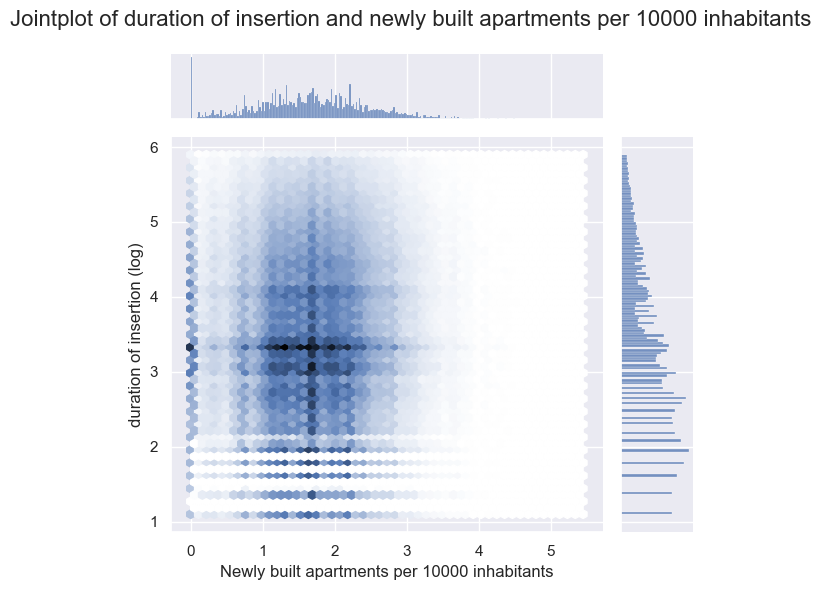

In [49]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(
    x="Newly built apartments per 10000 inhabitants",
    y="Insertionsdauer",
    data=df,
    kind="hex",
)
fig.fig.suptitle(
    "Jointplot of duration of insertion and newly built apartments per 10000 inhabitants",
    fontsize=16,
)
fig.set_axis_labels(
    "Newly built apartments per 10000 inhabitants",
    "duration of insertion (log)",
    fontsize=12,
)
fig.fig.tight_layout()
plt.show()

### Correlation to average household size

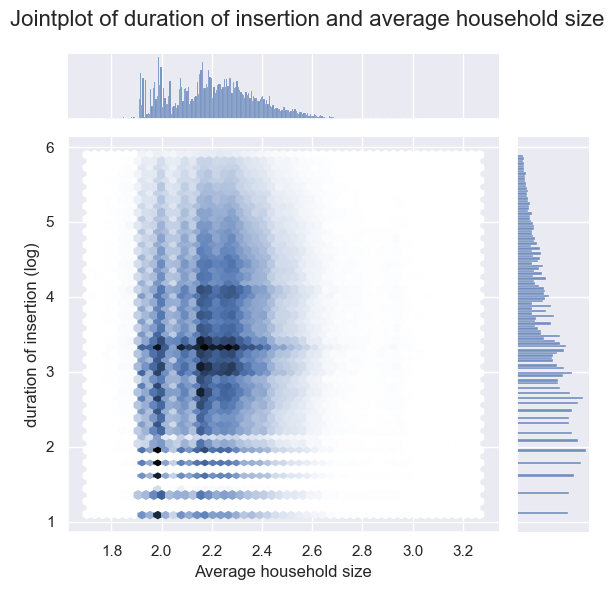

In [50]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(
    x="Average household size", y="Insertionsdauer", data=df, kind="hex"
)
fig.fig.suptitle(
    "Jointplot of duration of insertion and average household size", fontsize=16
)
fig.set_axis_labels(
    "Average household size", "duration of insertion (log)", fontsize=12
)
fig.fig.tight_layout()
plt.show()

### Correlation to single-family house residents

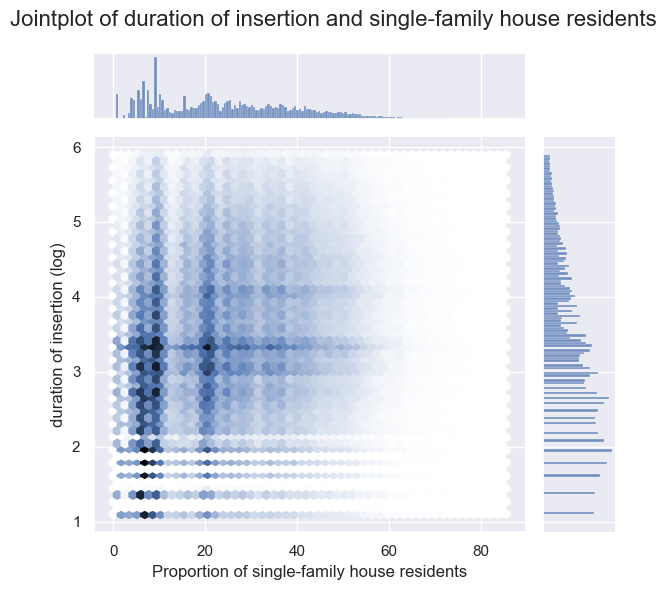

In [51]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(
    x="Proportion of single-family house residents",
    y="Insertionsdauer",
    data=df,
    kind="hex",
)
fig.fig.suptitle(
    "Jointplot of duration of insertion and single-family house residents", fontsize=16
)
fig.set_axis_labels(
    "Proportion of single-family house residents",
    "duration of insertion (log)",
    fontsize=12,
)
fig.fig.tight_layout()
plt.show()

### Correlation to population density

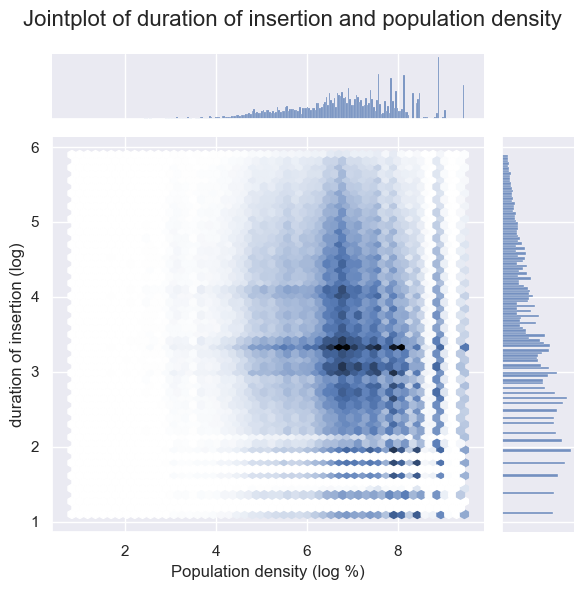

In [52]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(x="Population density", y="Insertionsdauer", data=df, kind="hex")
fig.fig.suptitle(
    "Jointplot of duration of insertion and population density", fontsize=16
)
fig.set_axis_labels(
    "Population density (log %)", "duration of insertion (log)", fontsize=12
)
fig.fig.tight_layout()
plt.show()

### Correlation to vacancy rate

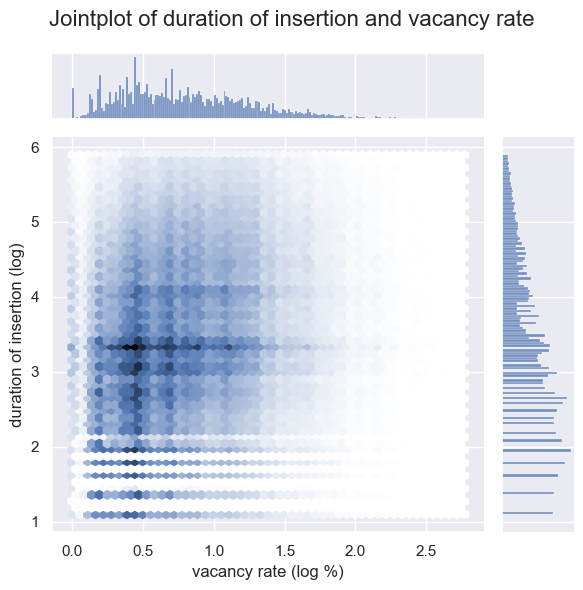

In [53]:
sns.set(rc={"figure.figsize": (6, 5)})

fig = sns.jointplot(x="Vacancy rate", y="Insertionsdauer", data=df, kind="hex")
fig.fig.suptitle("Jointplot of duration of insertion and vacancy rate", fontsize=16)
fig.set_axis_labels("vacancy rate (log %)", "duration of insertion (log)", fontsize=12)
fig.fig.tight_layout()
plt.show()

### Correlation to nominal variables

In [54]:
# Define the nominal variables of the DataFrame
df_nominal = df[
    [
        "Nutzung",
        "Nutzung detailliert",
        "Zustand",
        "Aussicht",
        "Balkon",
        "Bauperiode",
        "Minergie",
        "Parkplatz aussen",
        "Parkplatz innen",
        "Rollstuhlgängig",
        "Verfügbarkeitskategorie",
        "Jahr_Erste_Publikation",
        "Monat_Erste_Publikation",
    ]
]

In [55]:
# Establish number of columns and rows needed to plot all features
n_cols = 3
n_elements = len(df_nominal.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")
print(n_cols, n_rows)

3 5


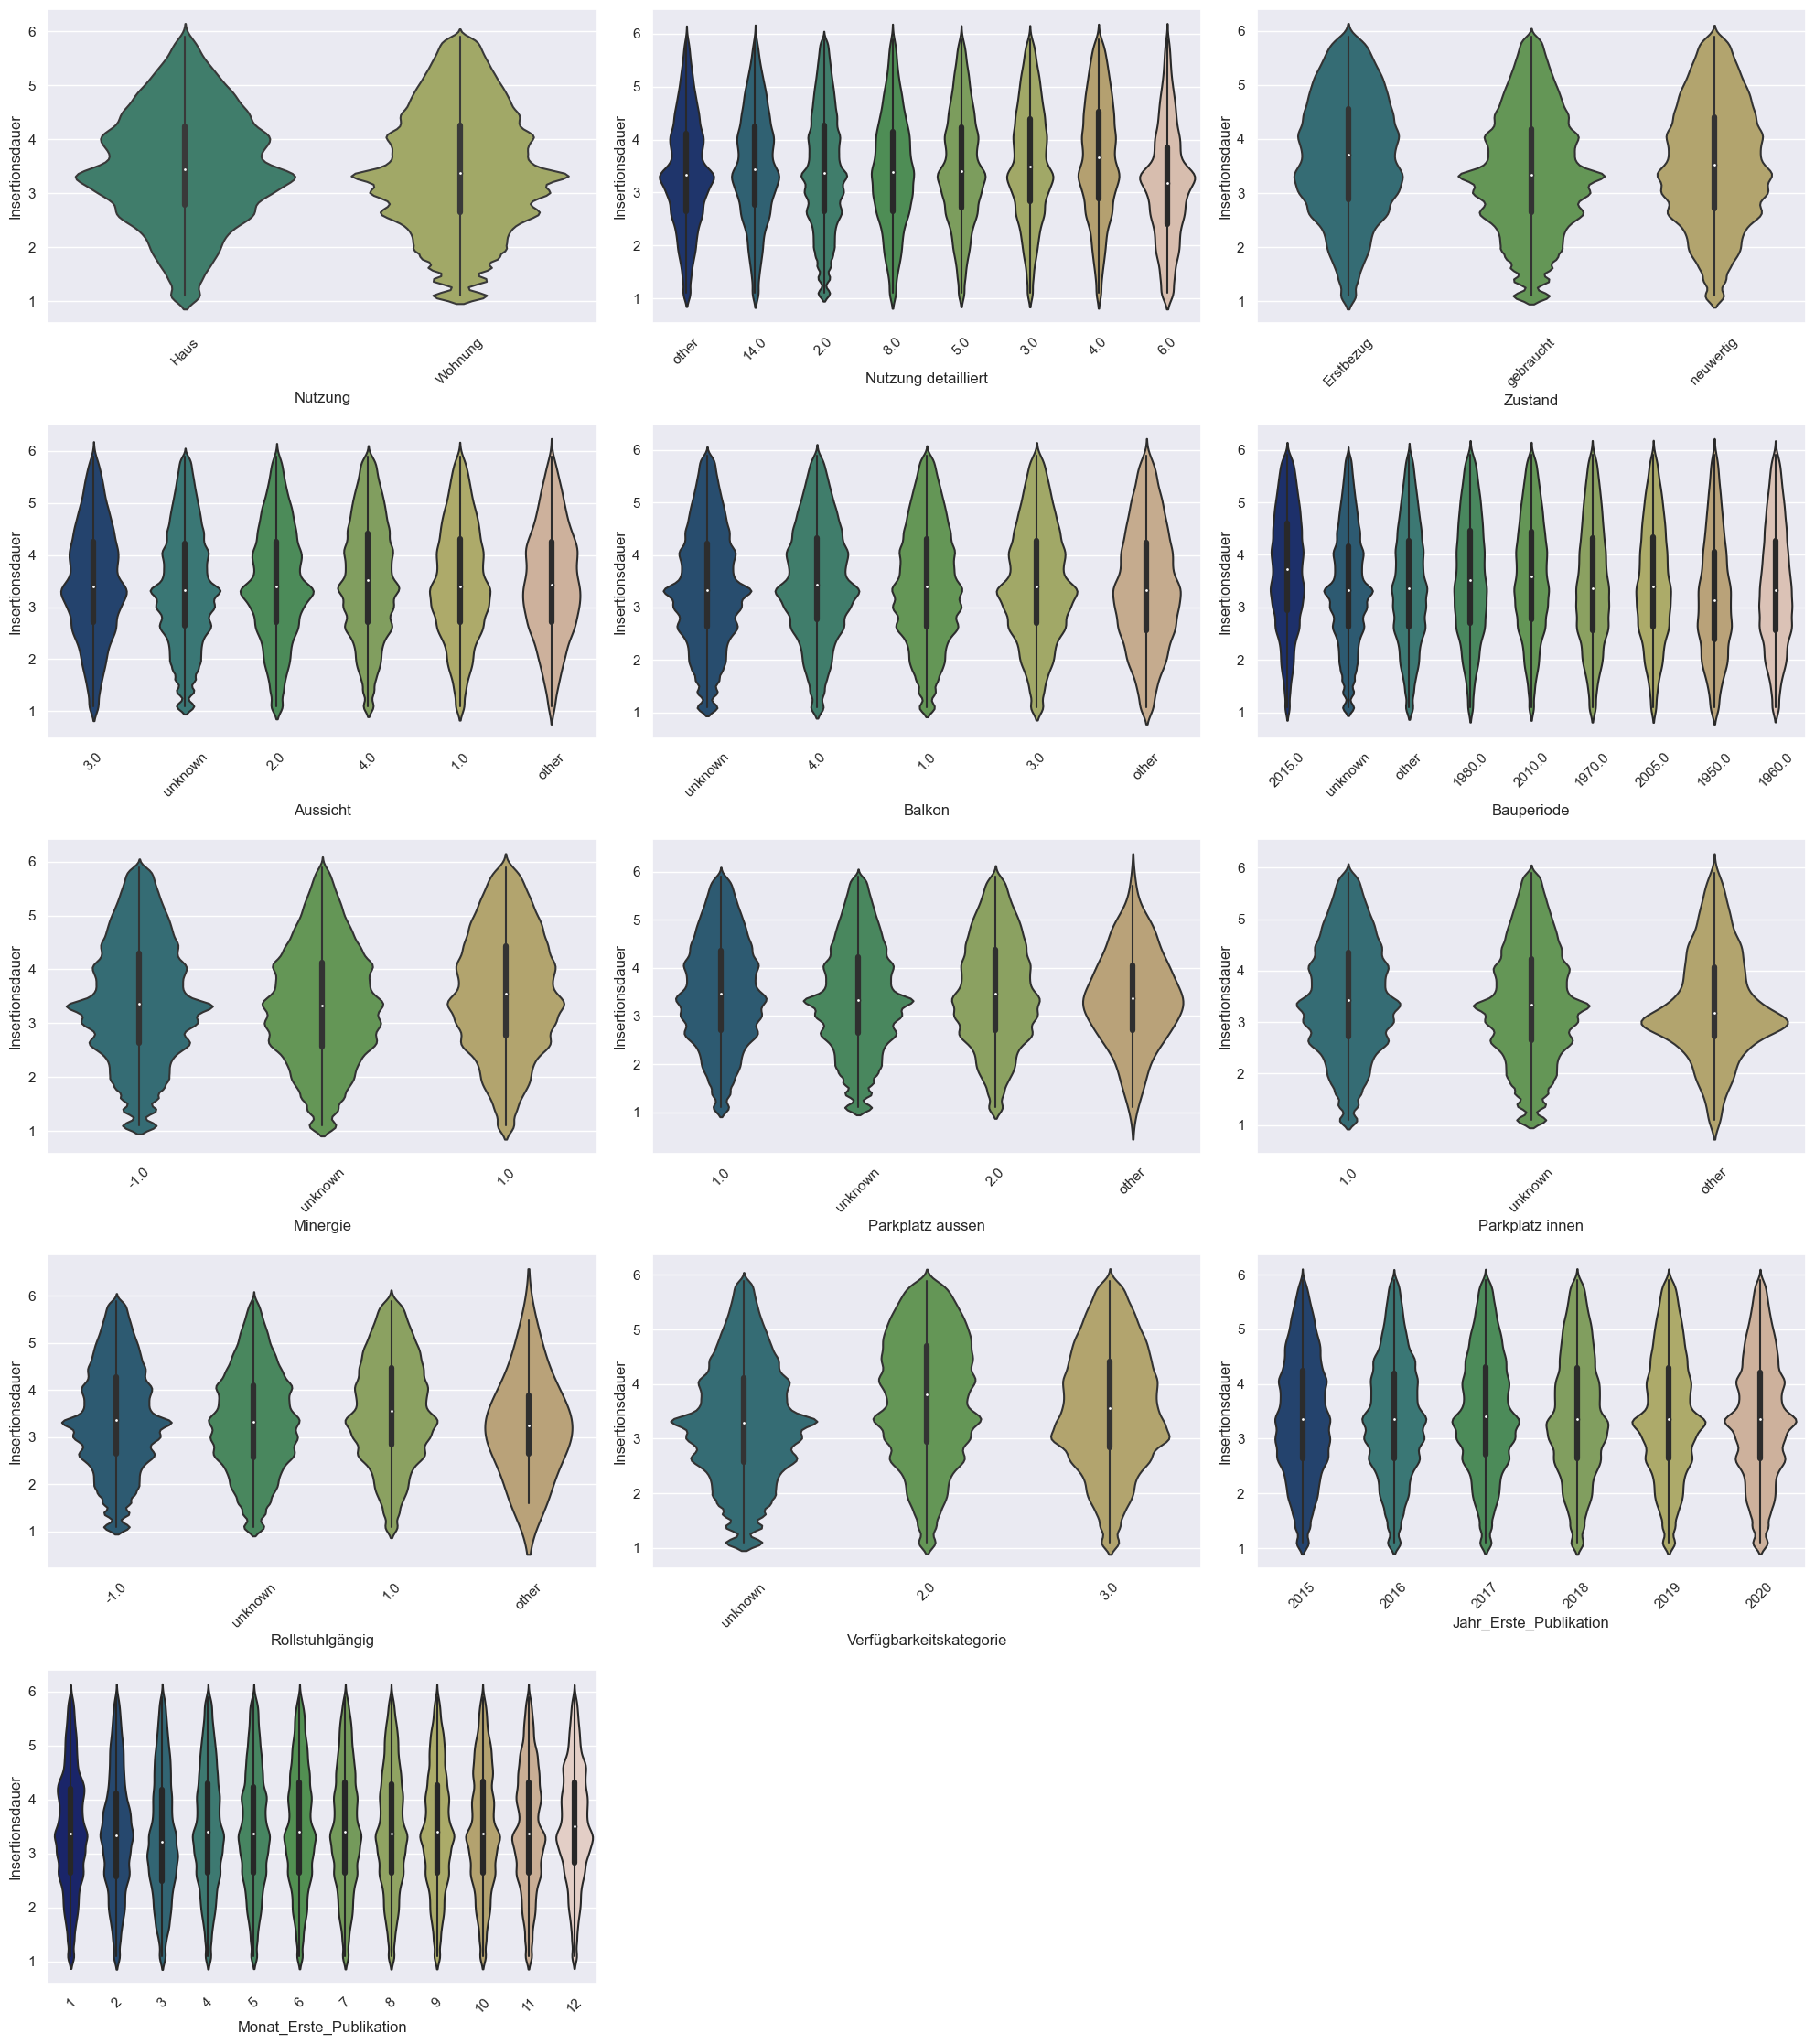

In [56]:
# plot the duration of inseration against the nominal varibales
import seaborn as sns

# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, n_rows * 4.5))

# Loop through these features and plot entries from each feature against `Insertionsdauer`
for col, ax in zip(df_nominal, axes.ravel()):
    sns.violinplot(
        data=df_nominal,
        x=col,
        y=df["Insertionsdauer"],
        ax=ax,
        palette="gist_earth",
        split=True,
    )

# xticklabels rotating by 45 degrees
# Source: https://github.com/matplotlib/matplotlib/issues/7150
for ax in axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# hide empty plots
fig.delaxes(axes[4][1])
fig.delaxes(axes[4][2])

plt.tight_layout()
plt.show()

The building period of 2015 has the longest mean duration of insertion whereas the building period "unknown" has the mean shorest duration.

## One-hot encoding

In a next step, I will use one-hot encoding for the nominal variables.

In [57]:
df = pd.get_dummies(
    df,
    columns=[
        "Nutzung",
        "Nutzung detailliert",
        "Zustand",
        "Aussicht",
        "Balkon",
        "Bauperiode",
        "Minergie",
        "Parkplatz aussen",
        "Parkplatz innen",
        "Rollstuhlgängig",
        "Verfügbarkeitskategorie",
        "Jahr_Erste_Publikation",
        "Monat_Erste_Publikation",
        "3 Gmd Kat",
        "9 Gmd Kat",
        "25 Gmd Kat",
        "Kanton",
    ],
)

In general, for one-hot encoded features multicollinearity is a problem. This is particularly true when it comes to plain linear problems. However, regularized or non-linear models can handle it better. As I plan to implement such models, I won't need the function drop_first for one-hot encoding.

In [58]:
# Current shape
print("Shape of df:", df.shape)

Shape of df: (921886, 143)


In [59]:
# Count how many times each data type is present in the dataset
pd.value_counts(df.dtypes)

uint8      131
float64     12
dtype: int64

In [60]:
# Show column names of type numeric
df.select_dtypes(include="float64").columns

Index(['Anzahl Zimmer', 'Insertionsdauer', 'Nettomiete pro m2 und Jahr',
       'Nettomiete pro Monat', 'Wohnfläche', 'Population density',
       'Proportion of single-family house residents', 'Average household size',
       'Newly built apartments per 10000 inhabitants',
       'Share of 3-4 room apartments', 'Vacancy rate', 'Insertionsdauer_n'],
      dtype='object')

## Correlation matrix

In [61]:
# drop columns
df = df.drop(["Insertionsdauer_n"], axis=1)

In [62]:
# get the correlation matrix for the numbers in df
df_numeric = df.select_dtypes(include="number")

# Compute the correlation matrix
df_numeric_corr = df_numeric.corr(method="pearson")

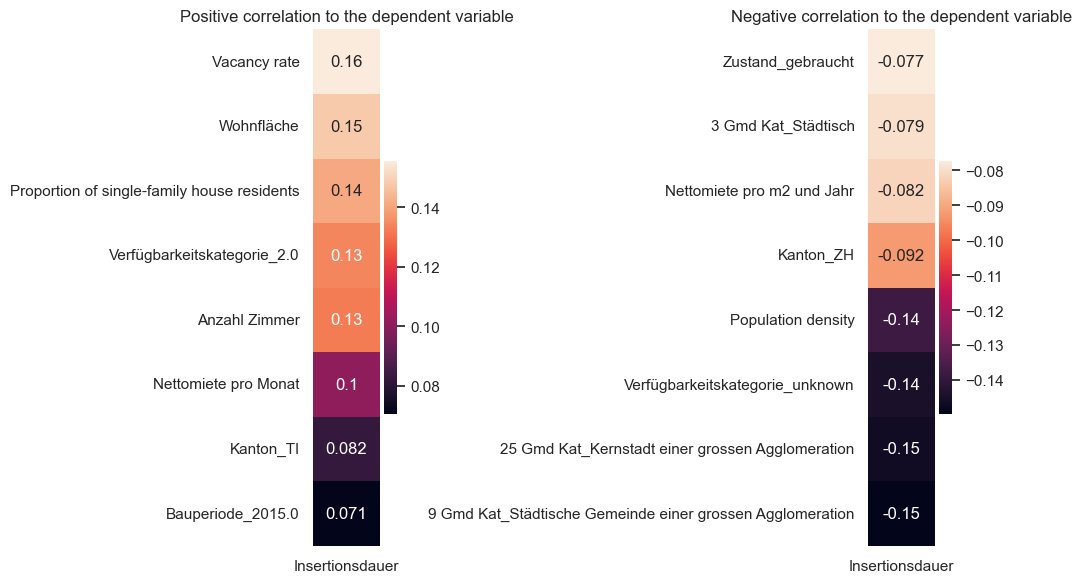

In [63]:
# Plot of correlations to the outcome variable 'Insertionsdauer'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# create DataFrame
df_Insert_corr = pd.DataFrame(
    df_numeric_corr.loc["Insertionsdauer"].sort_values(ascending=False)
)

# plot the top 8 correlations
sns.set(rc={"figure.figsize": (4, 6)})
sns.heatmap(df_Insert_corr.head(9)[-8:], annot=True, ax=ax1).set_title(
    "Positive correlation to the dependent variable"
)

# plot the bottom 8 correlations
sns.set(rc={"figure.figsize": (4, 6)})
sns.heatmap(df_Insert_corr.tail(8), annot=True, ax=ax2).set_title(
    "Negative correlation to the dependent variable"
)

plt.tight_layout()
plt.show()

The duration of insertion has some weak positive and negative linear correlations. There are some interessting patterns like:
* Vacancy rate: The more vacant apartments there are, the longer the duration of insertion.
* Surface area: the bigger the apartment's surface, the longer the duration of insertion
* Proportion of single-family house residents: the more residents in single-family houses, the longer the duration of insertion.

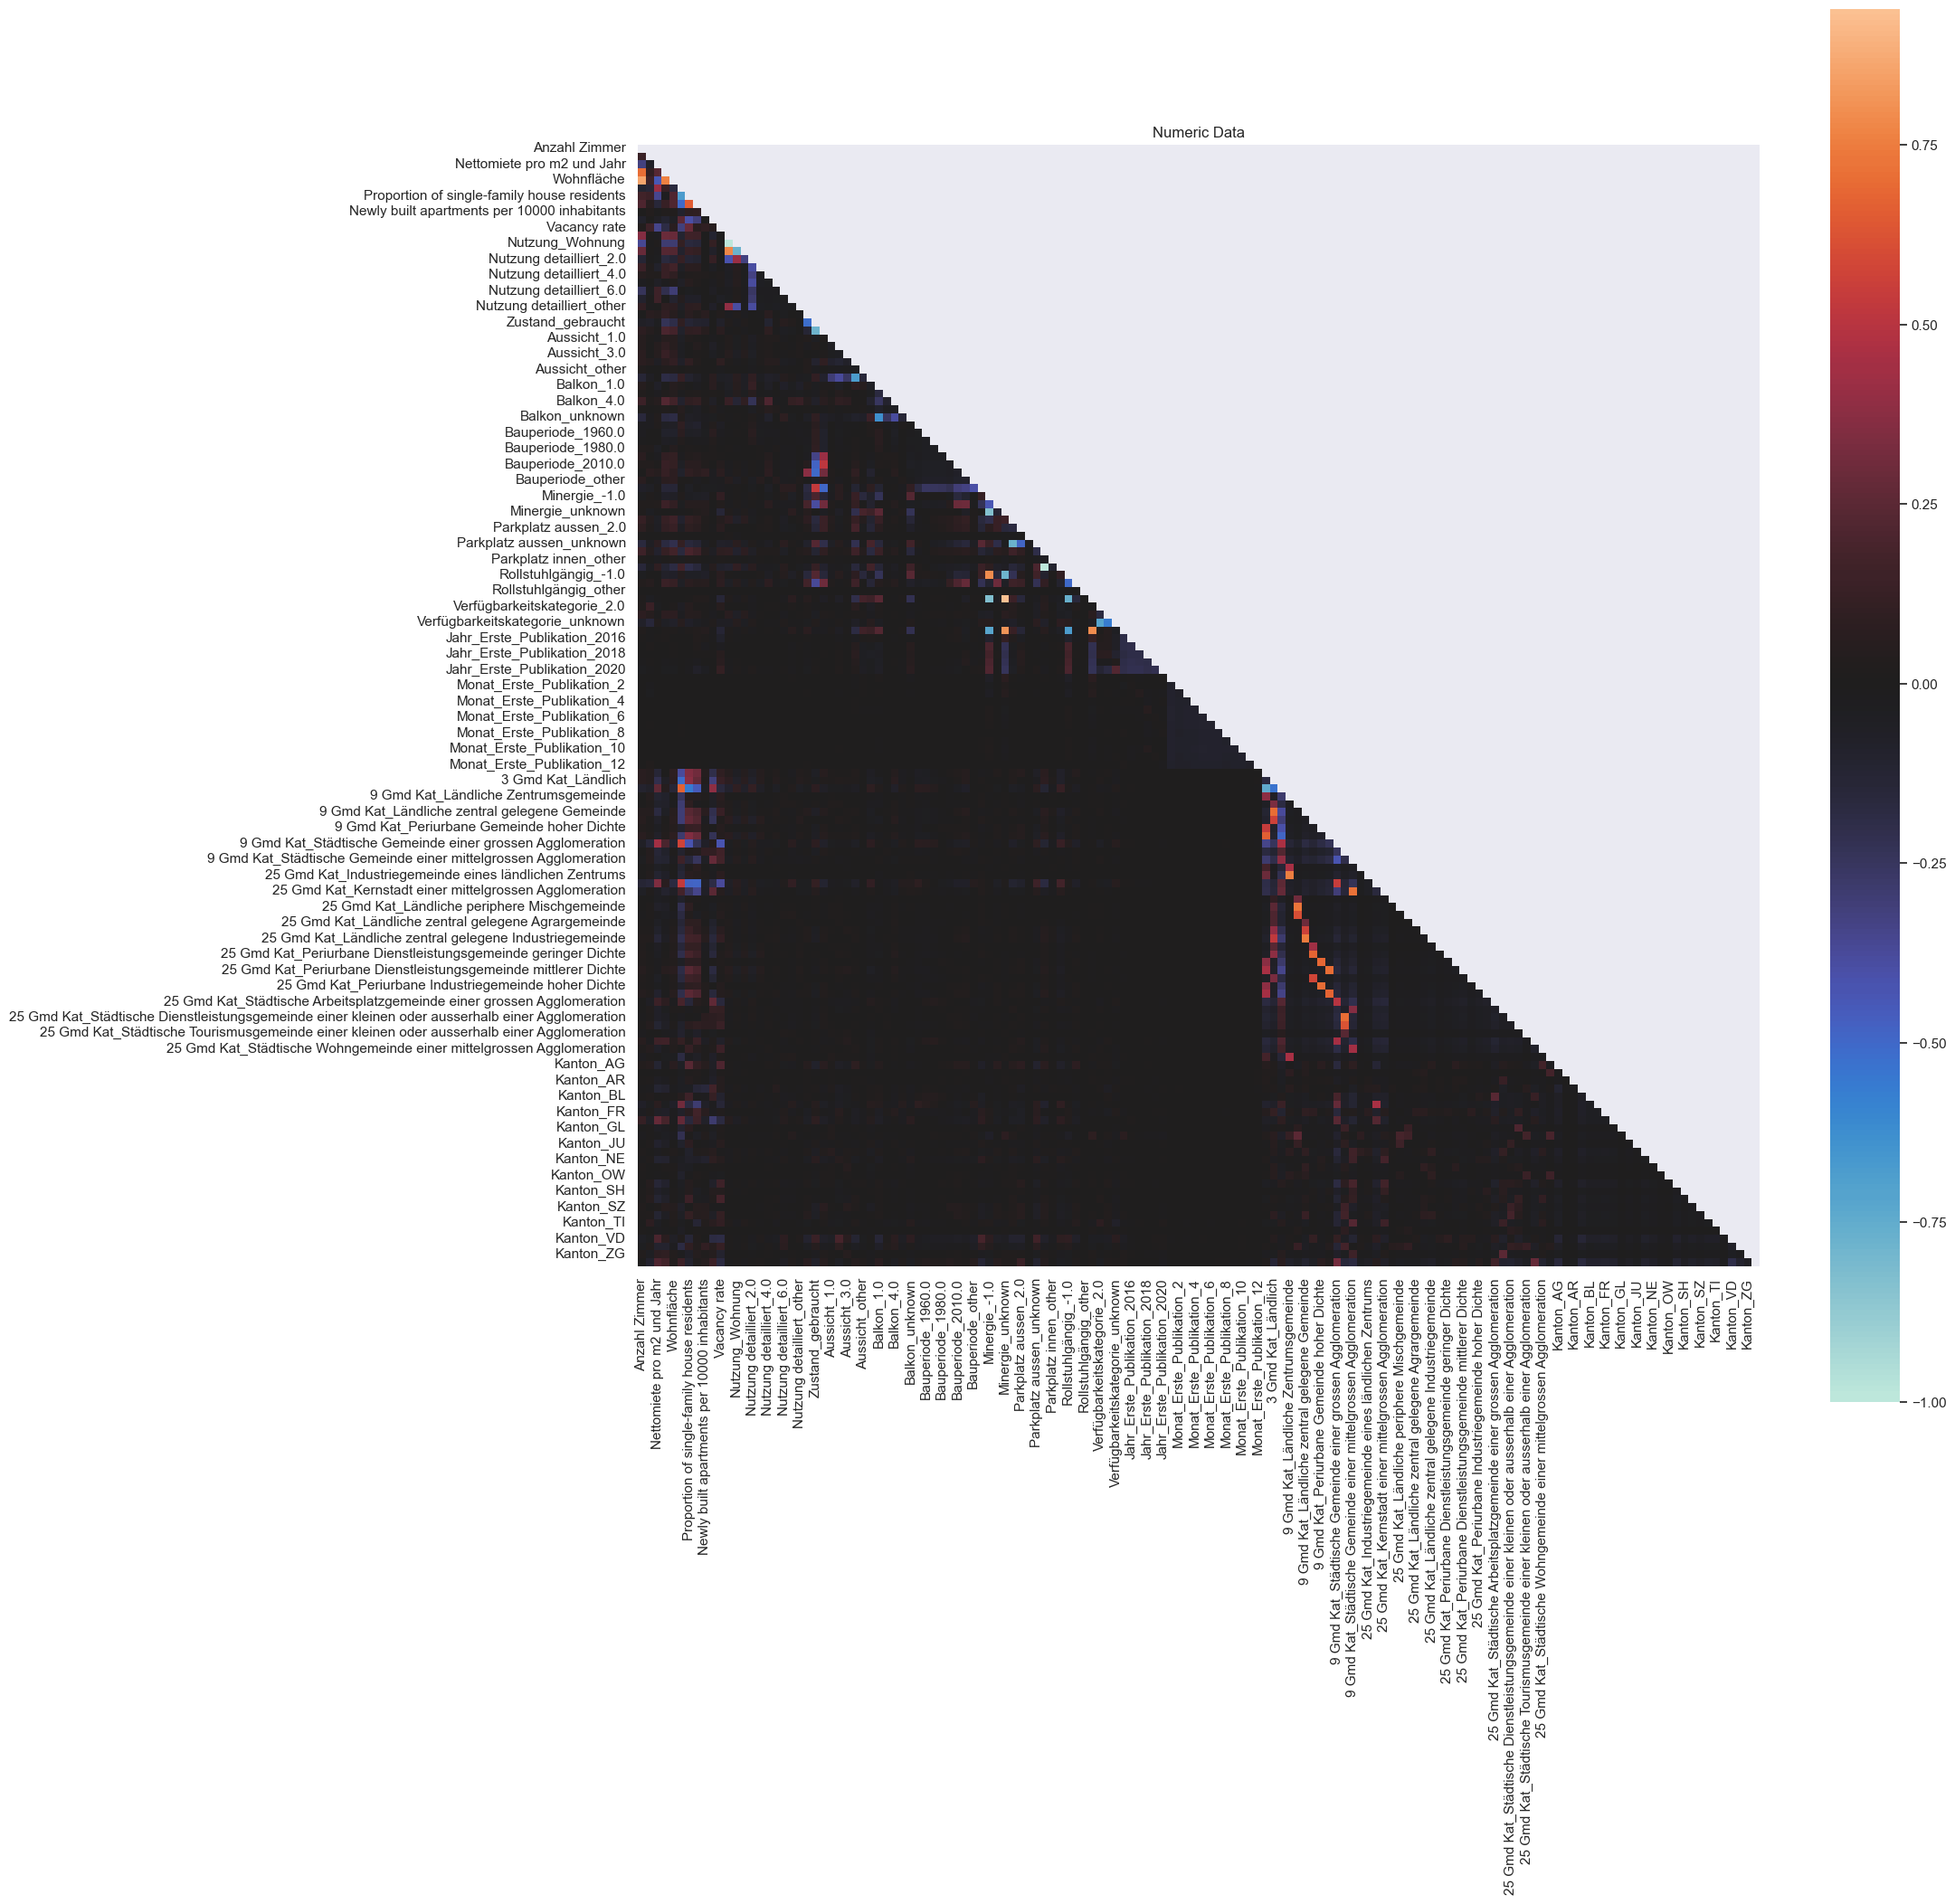

In [64]:
# Plot correlation matrix for all numeric variables
sns.set(rc={"figure.figsize": (20, 20)})

# Mask the upper part of the heatmap
mask_numeric = np.triu(np.ones_like(df_numeric_corr, dtype=bool))

# plot the correlation matrix
sns.heatmap(
    df_numeric_corr, annot=False, fmt="0.2f", center=0, square=True, mask=mask_numeric
).set_title("Numeric Data")

plt.show()

In general the EDA shows that I only have weak correlations for my target variable. For example the correlation matrix shows the most linerarly correlated feature at only  16%. However, these are linear correlations. As I'm not going to implement a linear model, there might be some other correlations helpful to predict my target variable.

But in general, the EDA shows that predicting the duration of insertion is not easy with this data. My models will be only as good as the data is, so possibibly my models will only make weak predictions. 

On the positive side, I have a huge dataframe and I believe the quality of the data is good enough. 

## Export

In [65]:
df.shape

(921886, 142)

In [66]:
# export to csv
from pathlib import Path

filepath = Path("Data/df_after_eda.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath, index=False)